## Importaciones y Configuración Inicial

In [1]:
import tensorflow as tf
print(f"Versión de TensorFlow: {tf.__version__}")
print("GPUs disponibles: ", tf.config.list_physical_devices('GPU'))

2025-10-30 17:37:03.384052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-30 17:37:03.384077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-30 17:37:03.384960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-30 17:37:03.389935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 17:37:04.059569: W tensorflow/compiler/tf2

Versión de TensorFlow: 2.15.1
GPUs disponibles:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-10-30 17:37:04.780802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-30 17:37:04.811141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-30 17:37:04.813134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## CARGA Y PREPARACIÓN DE DATOS

In [3]:
def load_cleaned_dataset():
    CLEANED_DATASET_PATH = "../data/processed/ddos_findef.csv"
    
    try:
        df_cleaned = pd.read_csv(CLEANED_DATASET_PATH)
        return df_cleaned
    except FileNotFoundError:
        exit()
    except Exception as e:
        exit()

# Carga y preparación de datos
df = load_cleaned_dataset()
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Idle Mean,y
0,4,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,3.000000e+06,5.000000e+05,329,0,1,20,0.0,0.0,0
1,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,1.200000e+07,2.000000e+06,329,0,1,20,0.0,0.0,0
2,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,1.200000e+07,2.000000e+06,329,0,1,20,0.0,0.0,0
3,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,1.200000e+07,2.000000e+06,329,0,1,20,0.0,0.0,0
4,3,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,4.000000e+06,6.666667e+05,245,0,1,20,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660372,196135,49,57,1331.0,105841.0,570.0,0.0,27.163265,4344.0,0.0,1856.859649,5.464196e+05,5.404441e+02,29200,61,31,20,0.0,0.0,0
2660373,378424,49,59,1325.0,104393.0,570.0,0.0,27.040816,2896.0,0.0,1769.372881,2.793639e+05,2.853942e+02,29200,61,30,20,0.0,0.0,0
2660374,161800,70,103,1427.0,215903.0,570.0,0.0,20.385714,4344.0,0.0,2096.145631,1.343201e+06,1.069221e+03,29200,61,47,20,0.0,0.0,0
2660375,142864,50,62,1331.0,110185.0,570.0,0.0,26.620000,2896.0,0.0,1777.177419,7.805745e+05,7.839624e+02,29200,61,31,20,0.0,0.0,0


In [4]:
if 'y' not in df.columns:
    print("Columna objetivo 'y' no encontrada")
    exit()

In [5]:
# Separar características y objetivo
feature_cols = [col for col in df.columns if col != 'y']
X = df[feature_cols].values
y = df['y'].values.astype(int)

print(f"Características: {X.shape[1]} variables")
print(f"Distribución de clases: {np.bincount(y)}")
print(f"   - BENIGN: {np.bincount(y)[0]:,} muestras")
print(f"   - ATTACK: {np.bincount(y)[1]:,} muestras")

Características: 19 variables
Distribución de clases: [2104911  555466]
   - BENIGN: 2,104,911 muestras
   - ATTACK: 555,466 muestras


### División y Escalado de Datos

In [ ]:
# División estratificada para mantener la proporción de clases
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [ ]:
# Escalado sin leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

input_dim = X_train.shape[1]

print(f"Datos divididos y escalados:")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Val:   {X_val.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")

Datos divididos y escalados:
   Train: 1,869,335 muestras
   Val:   400,572 muestras
   Test:  400,572 muestras


## LÍNEA BASE (BASELINE)

In [ ]:
# Entrenamiento del modelo baseline
start_time = time.time()
baseline_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1
)
baseline_model.fit(X_train, y_train)
train_time_base = time.time() - start_time

In [ ]:
# Evaluación
start_inf = time.time()
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
inf_time_base = (time.time() - start_inf) / len(X_test)
y_pred_base = (y_prob_base >= 0.5).astype(int)

In [ ]:
# Métricas
report_base = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)
roc_auc_base = roc_auc_score(y_test, y_prob_base)
pr_auc_base = average_precision_score(y_test, y_prob_base)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob_base)

print("Línea Base completada")
print(f"Tiempo entrenamiento: {train_time_base:.1f}s")
print(f"Latencia inferencia: {inf_time_base*1e6:.1f}µs/muestra")

Línea Base completada
Tiempo entrenamiento: 7.0s
Latencia inferencia: 0.0µs/muestra


## EXPERIMENTOS A/B (VARIANTE 1)

In [ ]:
# Configuración común
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)

### VARIANTE 1: AUTOENCODER + CNN-LSTM

In [ ]:
# Autoencoder
def build_autoencoder(input_dim, encoding_dim=32):
    inputs = layers.Input(shape=(input_dim,))
    
    # Encoder
    encoded = layers.Dense(256, activation='relu')(inputs)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    bottleneck = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(bottleneck)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = models.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [ ]:
# Entrenamiento Autoencoder
autoencoder = build_autoencoder(input_dim)
start_time = time.time()
history_ae = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, batch_size=512, 
    callbacks=[early_stop], verbose=1
)
train_time_ae = time.time() - start_time

Epoch 1/100
3652/3652 [==============================] - 12s 3ms/step - loss: 0.0085 - val_loss: 0.0022
Epoch 2/100
3652/3652 [==============================] - 11s 3ms/step - loss: 9.8579e-04 - val_loss: 0.0334
Epoch 3/100
3652/3652 [==============================] - 11s 3ms/step - loss: 7.0123e-04 - val_loss: 0.0016
Epoch 4/100
3652/3652 [==============================] - 11s 3ms/step - loss: 5.6270e-04 - val_loss: 0.0014
Epoch 5/100
3652/3652 [==============================] - 11s 3ms/step - loss: 4.8533e-04 - val_loss: 7.6847e-04
Epoch 6/100
3652/3652 [==============================] - 11s 3ms/step - loss: 4.9883e-04 - val_loss: 1.4925e-04
Epoch 7/100
3652/3652 [==============================] - 11s 3ms/step - loss: 3.8462e-04 - val_loss: 1.4376e-04
Epoch 8/100
3652/3652 [==============================] - 11s 3ms/step - loss: 4.0245e-04 - val_loss: 1.8644e-04
Epoch 9/100
3652/3652 [==============================] - 11s 3ms/step - loss: 3.3599e-04 - val_loss: 2.9018e-04
Epoch 10/100

In [ ]:
# Extracción de características
encoder = models.Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Z_train = encoder.predict(X_train, verbose=1)
Z_val = encoder.predict(X_val, verbose=1)
Z_test = encoder.predict(X_test, verbose=1)

12518/12518 [==============================] - 9s 737us/step


In [ ]:
# Preparación secuencial
def to_sequential_format(arr):
    return arr.reshape((arr.shape[0], arr.shape[1], 1))

Z_train_seq = to_sequential_format(Z_train)
Z_val_seq = to_sequential_format(Z_val)
Z_test_seq = to_sequential_format(Z_test)

In [ ]:
# Modelo CNN-LSTM
def build_cnn_lstm(seq_length):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=(seq_length, 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same'),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenamiento CNN-LSTM
cnn_lstm_model = build_cnn_lstm(Z_train_seq.shape[1])
start_time = time.time()
history_clf = cnn_lstm_model.fit(
    Z_train_seq, y_train,
    validation_data=(Z_val_seq, y_val),
    epochs=100, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_clf = time.time() - start_time

Epoch 1/100
3652/3652 [==============================] - 19s 5ms/step - loss: 0.6395 - accuracy: 0.6240 - val_loss: 0.6317 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 2/100
3652/3652 [==============================] - 17s 5ms/step - loss: 0.6317 - accuracy: 0.6336 - val_loss: 0.6243 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 3/100
3652/3652 [==============================] - 17s 5ms/step - loss: 0.6299 - accuracy: 0.6358 - val_loss: 0.6135 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 4/100
3652/3652 [==============================] - 17s 5ms/step - loss: 0.6288 - accuracy: 0.6366 - val_loss: 0.6664 - val_accuracy: 0.5928 - lr: 0.0010
Epoch 5/100
3652/3652 [==============================] - 17s 5ms/step - loss: 0.6278 - accuracy: 0.6365 - val_loss: 0.6117 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 6/100
3652/3652 [==============================] - 17s 5ms/step - loss: 0.6271 - accuracy: 0.6385 - val_loss: 0.6218 - val_accuracy: 0.6624 - lr: 0.0010
Epoch 7/100
3652/3652 [=======================

In [ ]:
# Evaluación Variante 1
start_inf = time.time()
y_prob_var1 = cnn_lstm_model.predict(Z_test_seq, verbose=1).ravel()
inf_time_var1 = (time.time() - start_inf) / len(Z_test_seq)
y_pred_var1 = (y_prob_var1 >= 0.5).astype(int)

report_var1 = classification_report(y_test, y_pred_var1, output_dict=True, zero_division=0)
roc_auc_var1 = roc_auc_score(y_test, y_prob_var1)
pr_auc_var1 = average_precision_score(y_test, y_prob_var1)
precision_var1, recall_var1, _ = precision_recall_curve(y_test, y_prob_var1)

train_time_var1 = train_time_ae + train_time_clf

print("Variante 1 completada")
print(f"Tiempo total: {train_time_var1:.1f}s")
print(f"Latencia: {inf_time_var1*1e6:.1f}µs/muestra")

12518/12518 [==============================] - 17s 1ms/step
Variante 1 completada
Tiempo total: 764.6s
Latencia: 49.8µs/muestra


### VARIANTE 2: MULTI-LAYER PERCEPTRON (MLP)

In [ ]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenamiento MLP
mlp_model = build_mlp(input_dim)
start_time = time.time()
history_mlp = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_var2 = time.time() - start_time

Epoch 1/100
3652/3652 [==============================] - 9s 2ms/step - loss: 0.6345 - accuracy: 0.6270 - val_loss: 0.6254 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 2/100
3652/3652 [==============================] - 8s 2ms/step - loss: 0.6251 - accuracy: 0.6371 - val_loss: 0.6058 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 3/100
3652/3652 [==============================] - 8s 2ms/step - loss: 0.6220 - accuracy: 0.6437 - val_loss: 0.6275 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 4/100
3652/3652 [==============================] - 8s 2ms/step - loss: 0.6204 - accuracy: 0.6469 - val_loss: 0.5909 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 5/100
3652/3652 [==============================] - 9s 2ms/step - loss: 0.6197 - accuracy: 0.6468 - val_loss: 0.6052 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 6/100
3652/3652 [==============================] - 9s 2ms/step - loss: 0.6191 - accuracy: 0.6450 - val_loss: 0.6160 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 7/100
3652/3652 [=============================

In [ ]:
# Evaluación Variante 2
start_inf = time.time()
y_prob_var2 = mlp_model.predict(X_test, verbose=1).ravel()
inf_time_var2 = (time.time() - start_inf) / len(X_test)
y_pred_var2 = (y_prob_var2 >= 0.5).astype(int)

report_var2 = classification_report(y_test, y_pred_var2, output_dict=True, zero_division=0)
roc_auc_var2 = roc_auc_score(y_test, y_prob_var2)
pr_auc_var2 = average_precision_score(y_test, y_prob_var2)
precision_var2, recall_var2, _ = precision_recall_curve(y_test, y_prob_var2)

print("Variante 2 completada")
print(f"Tiempo: {train_time_var2:.1f}s")
print(f"Latencia: {inf_time_var2*1e6:.1f}µs/muestra")

12518/12518 [==============================] - 10s 780us/step
Variante 2 completada
Tiempo: 122.5s
Latencia: 32.9µs/muestra


## RESULTADOS Y VISUALIZACIÓN

### Tabla Comparativa: Baseline vs. Variante 1

In [ ]:
# Tabla comparativa
results_data = {
    'Métrica': [
        'F1-Score (ATTACK) - Principal',
        'Precision (ATTACK)',
        'Recall (ATTACK)', 
        'Accuracy',
        'PR-AUC - Secundaria',
        'ROC-AUC',
        'Tiempo Entrenamiento (s)',
        'Latencia Inferencia (µs/muestra)'
    ],
    'Línea Base (Regresión Logística)': [
        f"{report_base['1']['f1-score']:.4f}",
        f"{report_base['1']['precision']:.4f}",
        f"{report_base['1']['recall']:.4f}",
        f"{report_base['accuracy']:.4f}",
        f"{pr_auc_base:.4f}",
        f"{roc_auc_base:.4f}",
        f"{train_time_base:.1f}",
        f"{inf_time_base*1e6:.1f}"
    ],
    'Variante 1 (AE + CNN-LSTM)': [
        f"{report_var1['1']['f1-score']:.4f}",
        f"{report_var1['1']['precision']:.4f}",
        f"{report_var1['1']['recall']:.4f}",
        f"{report_var1['accuracy']:.4f}",
        f"{pr_auc_var1:.4f}",
        f"{roc_auc_var1:.4f}",
        f"{train_time_var1:.1f}",
        f"{inf_time_var1*1e6:.1f}"
    ],
    'Variante 2 (MLP)': [
        f"{report_var2['1']['f1-score']:.4f}",
        f"{report_var2['1']['precision']:.4f}",
        f"{report_var2['1']['recall']:.4f}",
        f"{report_var2['accuracy']:.4f}",
        f"{pr_auc_var2:.4f}",
        f"{roc_auc_var2:.4f}",
        f"{train_time_var2:.1f}",
        f"{inf_time_var2*1e6:.1f}"
    ]
}

df_results = pd.DataFrame(results_data)
print("\n📋 TABLA COMPARATIVA")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


📋 TABLA COMPARATIVA
                         Métrica Línea Base (Regresión Logística) Variante 1 (AE + CNN-LSTM) Variante 2 (MLP)
   F1-Score (ATTACK) - Principal                           0.4166                     0.4413           0.4440
              Precision (ATTACK)                           0.3135                     0.3369           0.3508
                 Recall (ATTACK)                           0.6207                     0.6395           0.6048
                        Accuracy                           0.6366                     0.6616           0.6834
             PR-AUC - Secundaria                           0.3604                     0.3971           0.4038
                         ROC-AUC                           0.6825                     0.7131           0.7177
        Tiempo Entrenamiento (s)                              7.0                      764.6            122.5
Latencia Inferencia (µs/muestra)                              0.0                       49.8       

### Gráfico Único: Curva Precision-Recall

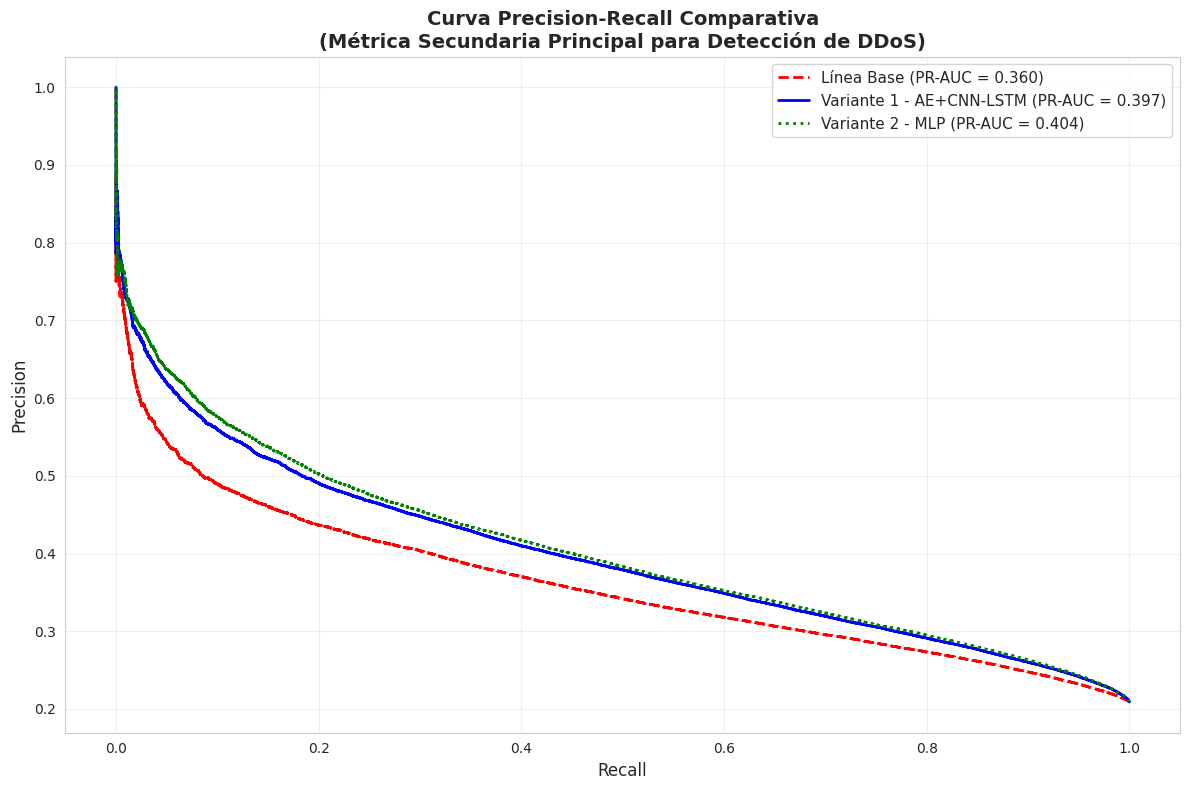

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(recall_base, precision_base, 
         label=f'Línea Base (PR-AUC = {pr_auc_base:.3f})', 
         color='red', linewidth=2, linestyle='--')
plt.plot(recall_var1, precision_var1, 
         label=f'Variante 1 - AE+CNN-LSTM (PR-AUC = {pr_auc_var1:.3f})', 
         color='blue', linewidth=2)
plt.plot(recall_var2, precision_var2, 
         label=f'Variante 2 - MLP (PR-AUC = {pr_auc_var2:.3f})', 
         color='green', linewidth=2, linestyle=':')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall Comparativa\n(Métrica Secundaria Principal para Detección de DDoS)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

TRADEOFF PRECISION-RECALL CON PUNTOS DE OPERACIÓN

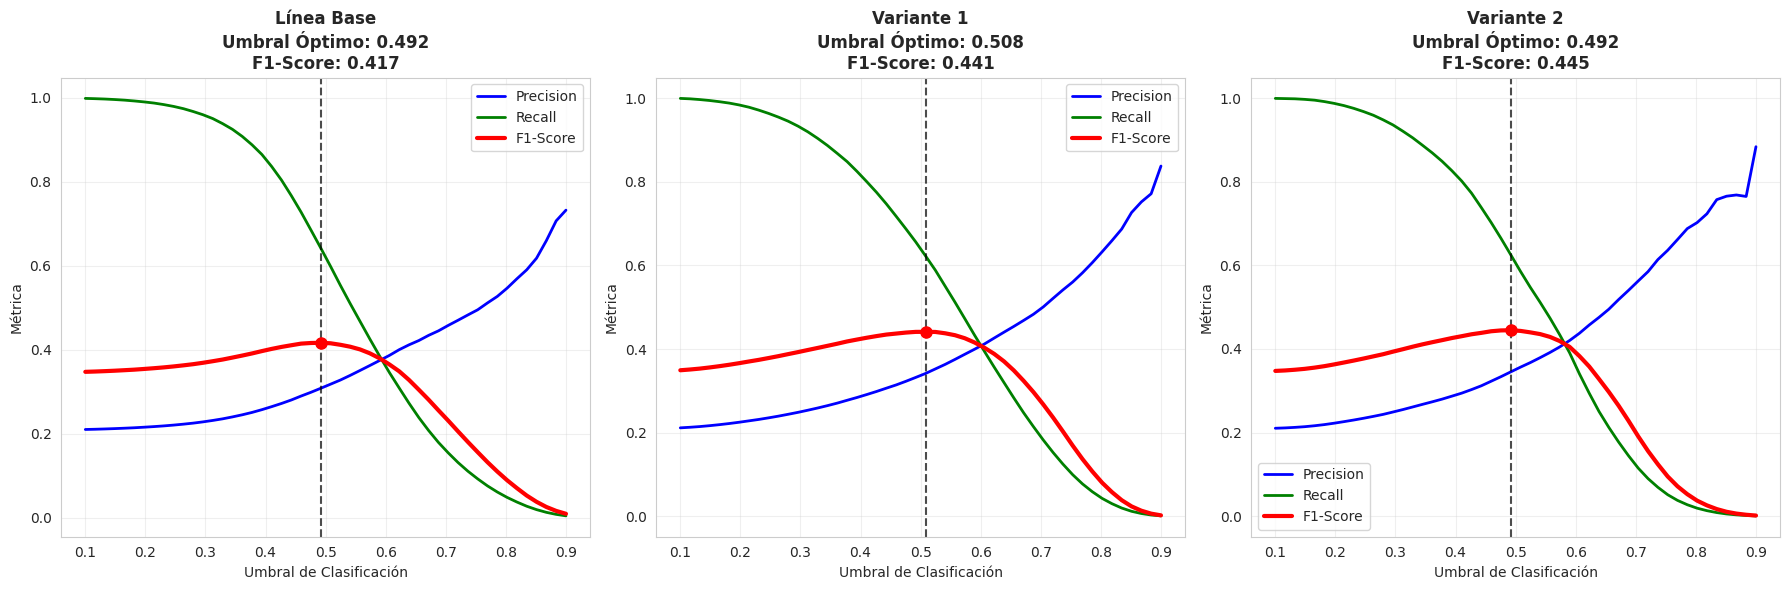

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (probs, model_name, color) in enumerate([
    (y_prob_base, 'Línea Base', 'red'),
    (y_prob_var1, 'Variante 1', 'blue'),
    (y_prob_var2, 'Variante 2', 'green')
]):
    # Calcular métricas para diferentes umbrales
    thresholds = np.linspace(0.1, 0.9, 50)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precisions.append(report['1']['precision'])
        recalls.append(report['1']['recall'])
        f1_scores.append(report['1']['f1-score'])
    
    # Encontrar umbral óptimo (max F1)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Graficar
    axes[idx].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[idx].plot(thresholds, recalls, 'g-', label='Recall', linewidth=2)
    axes[idx].plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=3)
    
    # Marcar punto óptimo
    axes[idx].axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7)
    axes[idx].plot(optimal_threshold, f1_scores[optimal_idx], 'ro', markersize=8)
    
    axes[idx].set_xlabel('Umbral de Clasificación')
    axes[idx].set_ylabel('Métrica')
    axes[idx].set_title(f'{model_name}\nUmbral Óptimo: {optimal_threshold:.3f}\nF1-Score: {f1_scores[optimal_idx]:.3f}', 
                       fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

COMPARACIÓN DE DETECCIÓN TEMPRANA (Recall@K)

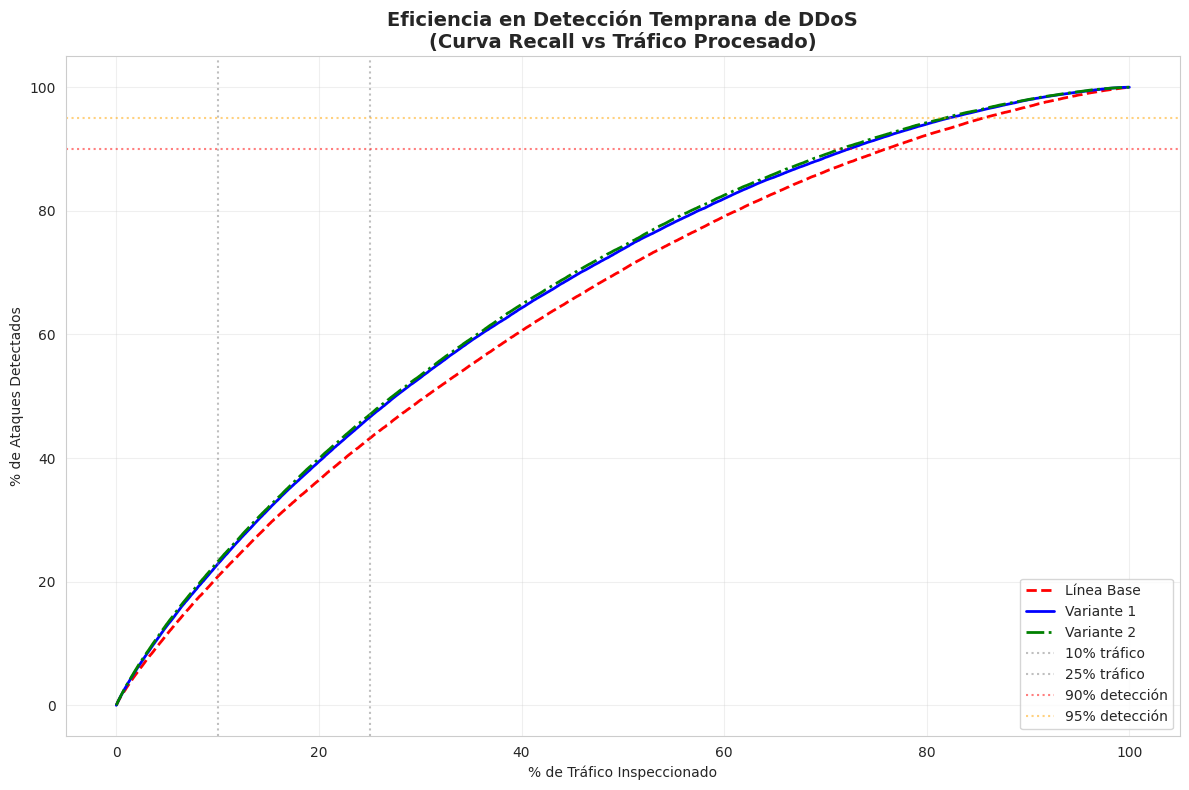

In [ ]:
plt.figure(figsize=(12, 8))

for probs, model_name, color, linestyle in [
    (y_prob_base, 'Línea Base', 'red', '--'),
    (y_prob_var1, 'Variante 1', 'blue', '-'),
    (y_prob_var2, 'Variante 2', 'green', '-.')
]:
    # Ordenar muestras por probabilidad descendente
    sorted_indices = np.argsort(probs)[::-1]
    sorted_labels = y_test[sorted_indices]
    
    # Calcular recall acumulado
    cumulative_attacks = np.cumsum(sorted_labels == 1)
    total_attacks = np.sum(y_test == 1)
    recall_at_k = cumulative_attacks / total_attacks
    
    # Porcentaje de tráfico inspeccionado
    traffic_inspected = np.arange(1, len(recall_at_k) + 1) / len(recall_at_k)
    
    plt.plot(traffic_inspected * 100, recall_at_k * 100, 
             label=model_name, color=color, linestyle=linestyle, linewidth=2)

plt.xlabel('% de Tráfico Inspeccionado')
plt.ylabel('% de Ataques Detectados')
plt.title('Eficiencia en Detección Temprana de DDoS\n(Curva Recall vs Tráfico Procesado)', 
          fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Marcadores clave
plt.axvline(x=10, color='gray', linestyle=':', alpha=0.5, label='10% tráfico')
plt.axvline(x=25, color='gray', linestyle=':', alpha=0.5, label='25% tráfico')
plt.axhline(y=90, color='red', linestyle=':', alpha=0.5, label='90% detección')
plt.axhline(y=95, color='orange', linestyle=':', alpha=0.5, label='95% detección')

plt.legend()
plt.tight_layout()
plt.show()

IMPACTO DE FALSOS POSITIVOS VS FALSOS NEGATIVOS

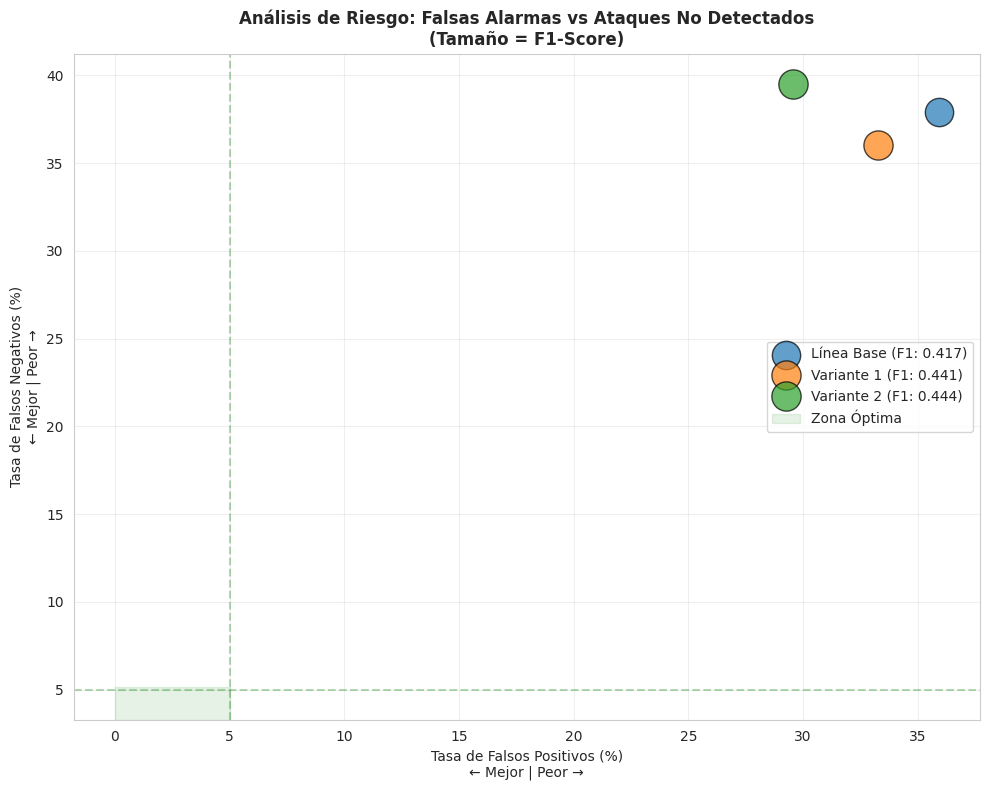

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Calcular FP y FN para cada modelo
fp_fn_data = []
model_names = ['Línea Base', 'Variante 1', 'Variante 2']
predictions = [y_pred_base, y_pred_var1, y_pred_var2]

for i, (y_pred, name) in enumerate(zip(predictions, model_names)):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fp_rate = fp / (fp + tn)  # Falsa alarma
    fn_rate = fn / (fn + tp)  # Ataque no detectado
    
    fp_fn_data.append((fp_rate, fn_rate, name))

# Scatter plot con burbujas proporcionales al F1-Score
f1_scores = [report_base['1']['f1-score'], report_var1['1']['f1-score'], report_var2['1']['f1-score']]
sizes = [score * 1000 for score in f1_scores]  # Tamaño proporcional al F1-Score

for i, (fp_rate, fn_rate, name) in enumerate(fp_fn_data):
    ax.scatter(fp_rate * 100, fn_rate * 100, s=sizes[i], alpha=0.7, 
               label=f'{name} (F1: {f1_scores[i]:.3f})', edgecolors='black')

ax.set_xlabel('Tasa de Falsos Positivos (%)\n← Mejor | Peor →')
ax.set_ylabel('Tasa de Falsos Negativos (%)\n← Mejor | Peor →')
ax.set_title('Análisis de Riesgo: Falsas Alarmas vs Ataques No Detectados\n(Tamaño = F1-Score)', 
             fontweight='bold', fontsize=12)

# Área óptima (esquina inferior izquierda)
ax.axvspan(0, 5, ymin=0, ymax=0.05, alpha=0.1, color='green', label='Zona Óptima')
ax.axhline(y=5, color='green', linestyle='--', alpha=0.3)
ax.axvline(x=5, color='green', linestyle='--', alpha=0.3)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ENDIMIENTO VS EFICIENCIA

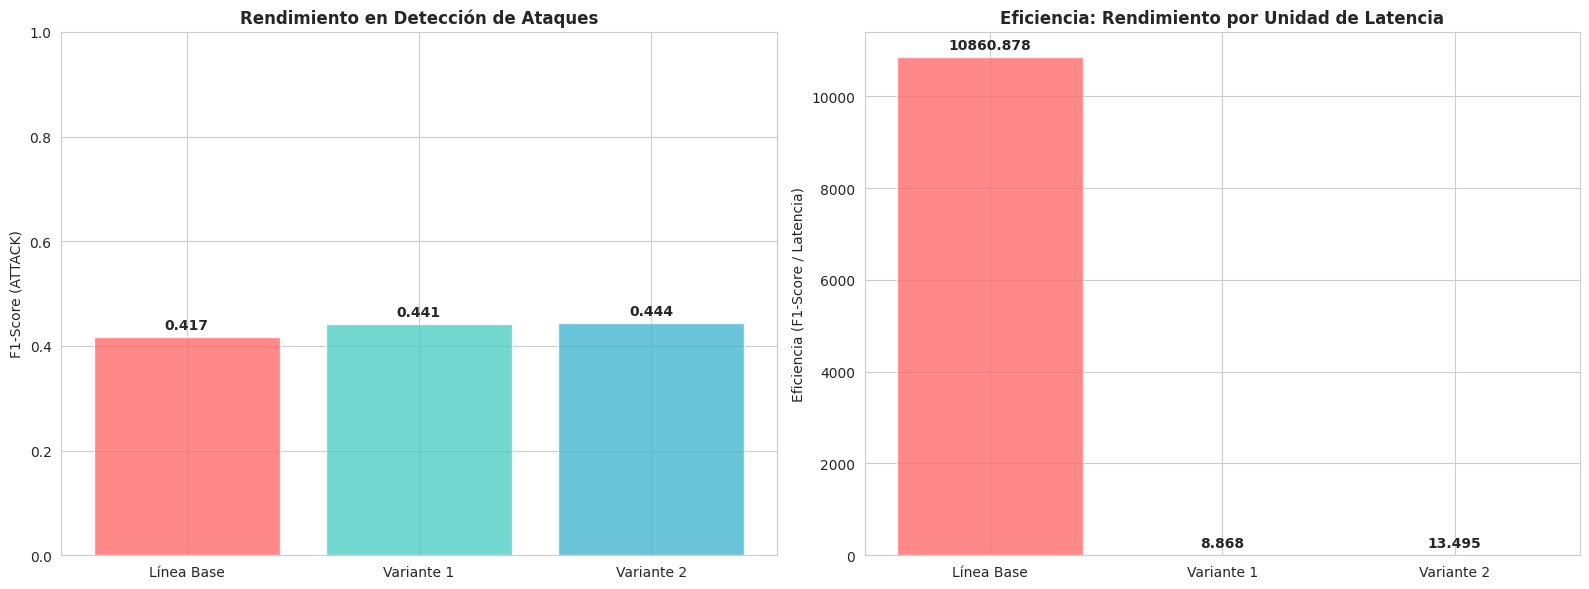

In [ ]:
# Crear métrica compuesta (F1-Score normalizado por latencia)
f1_scores = [report_base['1']['f1-score'], report_var1['1']['f1-score'], report_var2['1']['f1-score']]
latencies = [inf_time_base * 1000, inf_time_var1 * 1000, inf_time_var2 * 1000]  # ms
efficiency_scores = [f1 / lat for f1, lat in zip(f1_scores, latencies)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Rendimiento puro
bars1 = ax1.bar(model_names, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax1.set_ylabel('F1-Score (ATTACK)')
ax1.set_title('Rendimiento en Detección de Ataques', fontweight='bold')
ax1.set_ylim(0, 1)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Eficiencia (rendimiento/latencia)
bars2 = ax2.bar(model_names, efficiency_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax2.set_ylabel('Eficiencia (F1-Score / Latencia)')
ax2.set_title('Eficiencia: Rendimiento por Unidad de Latencia', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(efficiency_scores)*0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

ANÁLISIS DE CONFIANZA EN LAS PREDICCIONES

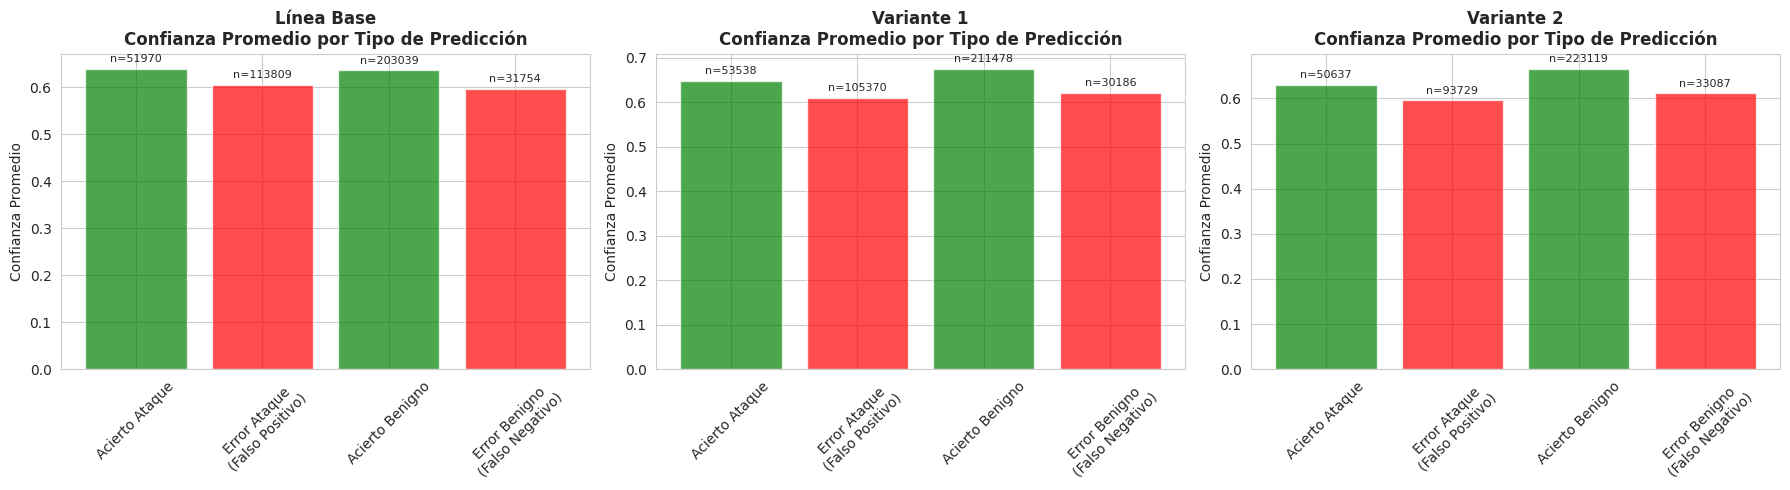

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (probs, preds, model_name) in enumerate([
    (y_prob_base, y_pred_base, 'Línea Base'),
    (y_prob_var1, y_pred_var1, 'Variante 1'),
    (y_prob_var2, y_pred_var2, 'Variante 2')
]):
    # Calcular confianza promedio por tipo de predicción
    correct_attack = probs[(y_test == 1) & (preds == 1)]
    incorrect_attack = probs[(y_test == 0) & (preds == 1)]
    correct_benign = 1 - probs[(y_test == 0) & (preds == 0)]
    incorrect_benign = 1 - probs[(y_test == 1) & (preds == 0)]
    
    categories = ['Acierto Ataque', 'Error Ataque\n(Falso Positivo)', 
                  'Acierto Benigno', 'Error Benigno\n(Falso Negativo)']
    confidences = [
        np.mean(correct_attack) if len(correct_attack) > 0 else 0,
        np.mean(incorrect_attack) if len(incorrect_attack) > 0 else 0,
        np.mean(correct_benign) if len(correct_benign) > 0 else 0,
        np.mean(incorrect_benign) if len(incorrect_benign) > 0 else 0
    ]
    counts = [len(correct_attack), len(incorrect_attack), 
              len(correct_benign), len(incorrect_benign)]
    
    bars = axes[idx].bar(categories, confidences, color=['green', 'red', 'green', 'red'], alpha=0.7)
    axes[idx].set_title(f'{model_name}\nConfianza Promedio por Tipo de Predicción', fontweight='bold')
    axes[idx].set_ylabel('Confianza Promedio')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Añadir conteos
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'n={count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Matriz de Decisión

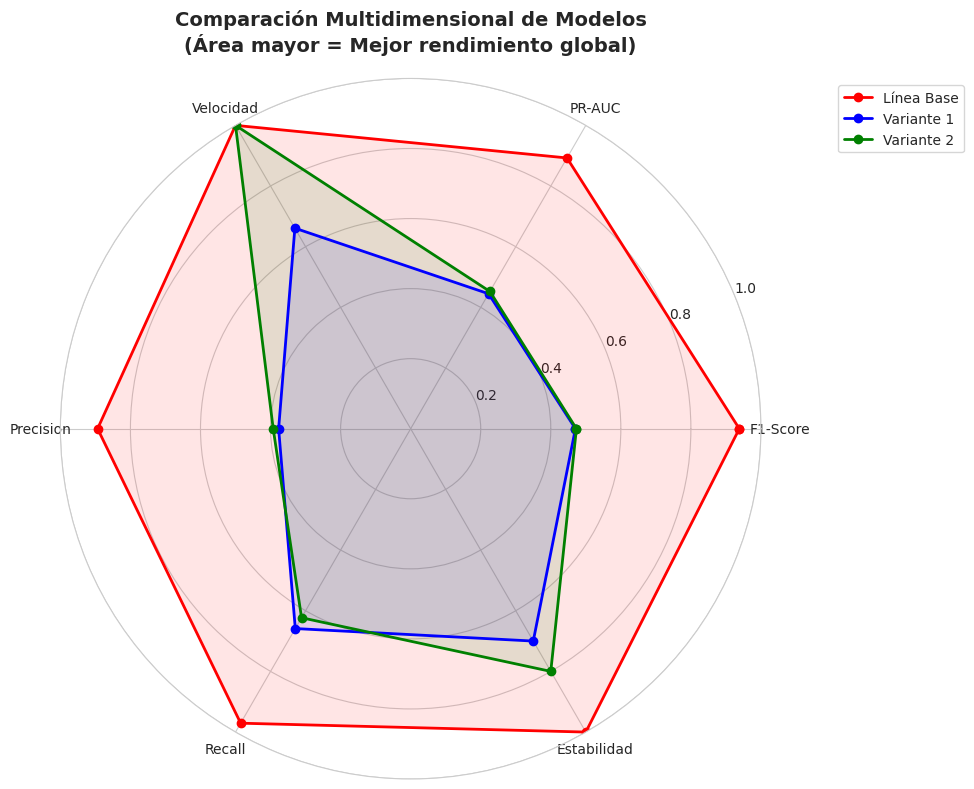

In [ ]:
criteria = ['F1-Score', 'PR-AUC', 'Velocidad', 'Precision', 'Recall', 'Estabilidad']
models_data = {
    'Línea Base': [f1_scores[0], pr_auc_base, 1/latencies[0], 
                   report_base['1']['precision'], report_base['1']['recall'], 0.9],
    'Variante 1': [f1_scores[1], pr_auc_var1, 1/latencies[1],
                   report_var1['1']['precision'], report_var1['1']['recall'], 0.7],
    'Variante 2': [f1_scores[2], pr_auc_var2, 1/latencies[2],
                   report_var2['1']['precision'], report_var2['1']['recall'], 0.8]
}

# Normalizar datos (0-1)
for key in models_data:
    models_data[key] = [x / max([models_data[m][i] for m in models_data]) 
                       for i, x in enumerate(models_data[key])]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

for model_name, color in [('Línea Base', 'red'), ('Variante 1', 'blue'), ('Variante 2', 'green')]:
    values = models_data[model_name]
    values += values[:1]  # Cerrar el círculo
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(criteria)
ax.set_ylim(0, 1)
ax.set_title('Comparación Multidimensional de Modelos\n(Área mayor = Mejor rendimiento global)', 
             fontweight='bold', fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

## 5. Validación y Sanidad
- **Split Estratificado:** Proporción de clases mantenida
- **Sin Leakage:** Scaler ajustado solo con training
- **Seeds Fijos:** random_state=42 para reproducibilidad
- **Evaluación Consistente:** Mismas métricas para todos

## 6. Conclusión y Decisión

In [ ]:
f1_scores = {
    'Línea Base': report_base['1']['f1-score'],
    'Variante 1': report_var1['1']['f1-score'], 
    'Variante 2': report_var2['1']['f1-score']
}

best_model_name = max(f1_scores, key=f1_scores.get)

## 7. Reproducibilidad

In [ ]:
# Guardar artefactos
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

print(f"\nGUARDANDO ARTEFACTOS EN: {checkpoint_dir.absolute()}")

# Guardar scaler y modelo seleccionado
joblib.dump(scaler, checkpoint_dir / "scaler.pkl")

if best_model_name == 'Variante 1':
    encoder.save(checkpoint_dir / "encoder.keras")
    cnn_lstm_model.save(checkpoint_dir / "classifier.keras")
    print("Autoencoder + CNN-LSTM guardado")
elif best_model_name == 'Variante 2':
    mlp_model.save(checkpoint_dir / "mlp_classifier.keras")
    print("MLP guardado")
else:
    joblib.dump(baseline_model, checkpoint_dir / "logistic_regression.pkl")
    print("Regresión Logística guardada")

# Guardar resultados
df_results.to_csv(checkpoint_dir / "model_comparison_results.csv", index=False)
print("Resultados comparativos guardados")

print(f"\nESTRUCTURA DE ARTEFACTOS:")
for file in checkpoint_dir.glob("*"):
    print(f"   • {file.name}")


GUARDANDO ARTEFACTOS EN: /home/byd-computer-ffq-u/proyects/Tesis_MIA2025-2/notebooks/checkpoints
MLP guardado
Resultados comparativos guardados

ESTRUCTURA DE ARTEFACTOS:
   • scaler.pkl
   • model_comparison_results.csv
   • mlp_classifier.keras



- **Comandos para Correr (README):**
    1.  Asegurarse de tener el dataset `dataset_final.csv` en la carpeta `../dataset/`.
    2.  Instalar las dependencias (`pip install -r requirements.txt`).
    3.  Ejecutar este script o notebook.

**Ubicación de Artefactos:** Los modelos finales y el scaler se guardan en la carpeta `./checkpoints/`.